Chi Zhang: czhang611@gatech.edu
Mengxiao Li: mengxiao.li@gatech.edu

idea reference: Buehler, Hans et al. Deep Hedging. SSRN Electronic Journal (2018): n. pag. Crossref. Web.

PyTorch Implementation: Fall 2020 Chi Zhang, Mengxiao Li. All rights reserved.

Re-optimized in the Spring 2022, Chi Zhang.

### package loading and see if GPU is available

In [ ]:
# load required basic packages
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# import deep learning packages
import torch
import torch.nn as nn
import torch.optim as optim

# inspect if we could use GPU
if torch.cuda.is_available():
  device = torch.device('cuda', 0)
else:
  device = torch.device('cpu')

### Loss functions: simple mean square error and two convex risk-adjusted metrics

In [ ]:
# basic metric
criterion = nn.MSELoss()

# loss_type = "Entropy" -> loss_param = lambda 
def entropy(wealth, loss_param=1.0):
    _lambda = loss_param
    return (1/_lambda) * torch.log(torch.mean(torch.exp(- _lambda * wealth)))

# loss_type = "CVaR" (Expected Shortfall) -> loss_param = alpha [0,100]
def CVaR(wealth, alpha=5):
    # _lambda = 1/(1-confidence_level)
    # w = torch.tensor([10**i for i in np.arange(10)])
    # # w = torch.tensor([1])
    # return torch.max(w - _lambda*torch.maximum(torch.zeros_like(wealth), torch.mean(w-wealth)))
    x_alpha = np.percentile(wealth.detach().numpy(), alpha)
    prct = torch.sum(wealth <= x_alpha)/float(len(wealth))
    y = wealth * ( wealth <= x_alpha )
    #return -1.0/alpha*(y.mean()+x_alpha*(alpha - prct))
    return  - y.mean() / prct

In [ ]:
# Functions in BS framework
# with torch stuff

def d1(S0, K, T, r, sigma):
    return (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

def d2(S0, K, T, r, sigma):
    return d1(S0, K, T, r, sigma) - sigma * np.sqrt(T)

def price_put_BS(S0, K, T, r, sigma):
    return (stats.norm.cdf(-d2(S0, K, T, r, sigma)) * K * np.exp(-r * T) - 
                           stats.norm.cdf(-d1(S0, K, T, r, sigma)) * S0)
def price_call_BS(S0, K, T, r, sigma):
    return (stats.norm.cdf(d1(S0, K, T, r, sigma)) * S0 - 
            stats.norm.cdf(d2(S0, K, T, r, sigma)) * K * np.exp(-r * T))

def delta_put_BS(S0, K, T, r, sigma):
    return -stats.norm.cdf(-d1(S0, K, T, r, sigma))

def delta_call_BS(S0, K, T, r, sigma):
    return stats.norm.cdf(d1(S0, K, T, r, sigma));

def price_call_spread(S0, K1, K2, T, r, sigma):
    if K1 > K2:
        res = price_call_BS(S0, K2, T, r, sigma) - price_call_BS(S0, K1, T, r, sigma)
    else:
        res = price_call_BS(S0, K1, T, r, sigma) - price_call_BS(S0, K2, T, r, sigma)
    return res

def delta_call_spread(S0, K1, K2, T, r, sigma):
    if K1 > K2:
        res = delta_call_BS(S0, K2, T, r, sigma) - delta_call_BS(S0, K1, T, r, sigma)
    else:
        res = delta_call_BS(S0, K1, T, r, sigma) - delta_call_BS(S0, K2, T, r, sigma)
    return res

# Simu Parameters
S0 = 100
K = 100
T = 1/12 # one month
T_delta = T/22 # one day
r = 0.05
sigma = 0.3
num_samples = 12000
num_epochs  = 20
batch_size = 200
S0_lower_bound = 90
S0_upper_bound = 110
tc_ratio = 0.005 # proportion tc 
tc_const = S0 * 0.5 * tc_ratio  # fixed tc calculated with init price S0

### Toy model 1: use a simple NN to directly fit BS delta; no risk-free or bond investment
In the direct fitting part, we set the information set input as the sampled uniform random variables. We will further refine this informaiton set input in the following models. Besides, all the toy models are built for single european options, we may explore hedging call/put spread portfolios in the final part.

In [ ]:
# Construct Neural Net

class Toy_Net1(nn.Module):
    
    def __init__(self, in_feat):
        super(Toy_Net1, self).__init__()
        self.lin1 = nn.Linear(in_feat, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.sig1 = nn.Sigmoid();
        self.lin2 = nn.Linear(16, 1)
        self.bn2 = nn.BatchNorm1d(1)
        self.sig2 = nn.Sigmoid();
        
    def forward(self, S0):
        out = self.lin1(S0)
        out = self.bn1(out)
        out = self.sig1(out)
        out = self.lin2(out)
        out = self.bn2(out)
        out = self.sig2(out)
        return out    

In [ ]:
uniform_samples = np.random.rand(num_samples, 1)
S0_values = (S0_upper_bound - S0_lower_bound) * uniform_samples + S0_lower_bound

delta_values = delta_call_BS(S0_values, K, T, r, sigma)

In [ ]:
# Create Data Loaders

training_set = torch.utils.data.TensorDataset(torch.Tensor(uniform_samples[:10000,:]), torch.Tensor(delta_values[:10000,:]))
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
testing_set = torch.utils.data.TensorDataset(torch.Tensor(uniform_samples[10000:,:]), torch.Tensor(delta_values[10000:,:]))
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size, shuffle=True)

In [ ]:
def train(model, device, training_loader, optimizer, epoch):
    # epoch means which epoch where are we, instead of total num of epochs
    model.train() # declare train mode, so that we keep the grads
    total_loss = 0
    for idx, data in enumerate(training_loader, 0):
        inputs, targets = data # a batch of data

        # 1. Forward
        outputs = model(inputs)
        
        # 2. Loss
        loss = criterion(outputs, targets)
        
        # 3. Zero the parameter gradients
        optimizer.zero_grad()
        
        # 4. Comp grad
        loss.backward()
        
        # 5. One step forward
        optimizer.step()
        
        
        total_loss += loss.item()
    
    print("Train Epoch: {}, Loss per batch: {}".format(epoch, round(total_loss/len(training_loader), 4)))
    train_loss_hist.append(total_loss/len(training_loader))

def test(model, device, testing_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad(): # not set train mode, instead declare no grads required
        for idx, data in enumerate(testing_loader, 0):
            inputs, targets = data
            
            # 1. Forward
            outputs = model(inputs)
        
            # 2. Loss
            loss = criterion(outputs, targets)
            
            total_loss += loss.item() 

    print("Test loss per batch: {}".format(round(total_loss/len(testing_loader),4)))
    val_loss_hist.append(total_loss/len(testing_loader))

### use SGD optimizer in the current section

Train Epoch: 0, Loss per batch: 0.1961
Test loss per batch: 0.1263
Train Epoch: 1, Loss per batch: 0.1693
Test loss per batch: 0.1203
Train Epoch: 2, Loss per batch: 0.0179
Test loss per batch: 0.0055
Train Epoch: 3, Loss per batch: 0.0055
Test loss per batch: 0.0045
Train Epoch: 4, Loss per batch: 0.0048
Test loss per batch: 0.004
Train Epoch: 5, Loss per batch: 0.0041
Test loss per batch: 0.0036
Train Epoch: 6, Loss per batch: 0.0035
Test loss per batch: 0.0032
Train Epoch: 7, Loss per batch: 0.0031
Test loss per batch: 0.0028
Train Epoch: 8, Loss per batch: 0.0028
Test loss per batch: 0.0023
Train Epoch: 9, Loss per batch: 0.0023
Test loss per batch: 0.0021
Train Epoch: 10, Loss per batch: 0.0021
Test loss per batch: 0.0018
Train Epoch: 11, Loss per batch: 0.0019
Test loss per batch: 0.0016
Train Epoch: 12, Loss per batch: 0.0016
Test loss per batch: 0.0015
Train Epoch: 13, Loss per batch: 0.0017
Test loss per batch: 0.0012
Train Epoch: 14, Loss per batch: 0.0014
Test loss per batch

Text(0, 0.5, 'Delta')

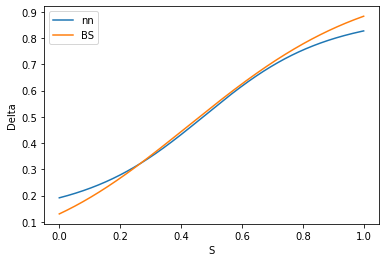

In [ ]:
model = Toy_Net1(in_feat = 1).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
train_loss_hist = []
val_loss_hist = []
for epoch in range(num_epochs):
  train(model, device, training_loader, optimizer, epoch)
  test(model, device, testing_loader)

# visualize the final fitted delta
standard_states = np.linspace(0, 1, num=1000, endpoint=True).reshape(-1,1)
standard_BS_delta = delta_call_BS((S0_upper_bound-S0_lower_bound)*standard_states + 
                                  S0_lower_bound, K, T, r, sigma)

# after training the model, make sure set the mode to be model.eval()
model.eval()
predictions = model(torch.Tensor(standard_states))

plt.figure(1)
l1, = plt.plot(standard_states, predictions.detach().numpy())
l2, = plt.plot(standard_states, standard_BS_delta)
plt.legend(handles=[l1,l2], labels=['nn','BS'], loc='best')
plt.xlabel('S')
plt.ylabel('Delta')

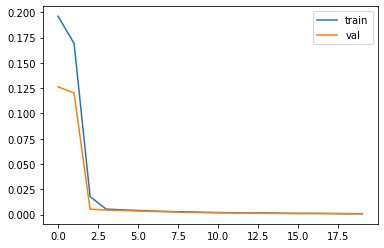

In [ ]:
plt.figure(1)
l1, = plt.plot(train_loss_hist)
l2, = plt.plot(val_loss_hist)
plt.legend(handles=[l1,l2], labels=['train','val'], loc='best')

### Learning a one-step hedge

In [ ]:
uniform_samples = np.random.rand(num_samples, 1)
normal_samples = np.random.randn(num_samples, 1)
S0_values = (S0_upper_bound - S0_lower_bound) * uniform_samples + S0_lower_bound
S1_values = S0_values * np.exp((r-0.5*sigma**2)*T_delta + sigma*np.sqrt(T_delta)*normal_samples)
S_mat = np.hstack((S0_values, S1_values)) # stack multiple columns horizontally together

call_values = price_call_BS(S0_values, K, T_delta, r, sigma)

training_set = torch.utils.data.TensorDataset(torch.Tensor(uniform_samples[:10000,:]),
        torch.Tensor(S_mat[:10000,:]),                                      
        torch.Tensor(call_values[:10000,:]))
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

testing_set = torch.utils.data.TensorDataset(torch.Tensor(uniform_samples[10000:,:]),
        torch.Tensor(S_mat[10000:,:]),
        torch.Tensor(call_values[10000:,:]))
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size, shuffle=True)

In [ ]:
def train(model, device, training_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for idx, data in enumerate(training_loader, 0):
        inputs, S_mat, C0 = data;
    
        # Forward
        outputs = model(inputs)
        
        # Loss
        loss = criterion(outputs * (S_mat[:,1:] - S_mat[:,0:1]) + C0, 
                         torch.max(S_mat[:,1:] - K, torch.zeros(batch_size, 1)))
        # meaning: let delta * change of underlying + init income of writing the call = call payoff at expiration
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Comp grad
        loss.backward()
        
        # One step forward
        optimizer.step()
        
        total_loss += loss.item()
        
    print("Train Epoch: {}, Loss per batch: {}".format(epoch, round(total_loss/len(training_loader),4)))
    train_loss_hist.append(total_loss/len(training_loader))

def test(model, device, testing_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for idx, data in enumerate(testing_loader, 0):
            inputs, S_mat, C0 = data;
    
            # Forward
            outputs = model(inputs)
            
            # Loss
            loss = criterion(outputs * (S_mat[:,1:] - S_mat[:,0:1]) + C0, 
                             torch.max(S_mat[:,1:] - K, torch.zeros(batch_size, 1)))
            
            total_loss += loss.item() 

    print("Test loss per batch: {}".format(round(total_loss/len(testing_loader),4)))
    val_loss_hist.append(total_loss/len(testing_loader))

Train Epoch: 0, Loss per batch: 0.4822
Test loss per batch: 0.5337
Train Epoch: 1, Loss per batch: 0.2108
Test loss per batch: 0.2044
Train Epoch: 2, Loss per batch: 0.1739
Test loss per batch: 0.1018
Train Epoch: 3, Loss per batch: 0.1541
Test loss per batch: 0.137
Train Epoch: 4, Loss per batch: 0.1416
Test loss per batch: 0.1328
Train Epoch: 5, Loss per batch: 0.1303
Test loss per batch: 0.1554
Train Epoch: 6, Loss per batch: 0.1179
Test loss per batch: 0.0944
Train Epoch: 7, Loss per batch: 0.1176
Test loss per batch: 0.1077
Train Epoch: 8, Loss per batch: 0.1118
Test loss per batch: 0.1039
Train Epoch: 9, Loss per batch: 0.1063
Test loss per batch: 0.1203
Train Epoch: 10, Loss per batch: 0.0941
Test loss per batch: 0.0658
Train Epoch: 11, Loss per batch: 0.0934
Test loss per batch: 0.0682
Train Epoch: 12, Loss per batch: 0.0873
Test loss per batch: 0.0684
Train Epoch: 13, Loss per batch: 0.0855
Test loss per batch: 0.0861
Train Epoch: 14, Loss per batch: 0.0852
Test loss per batch

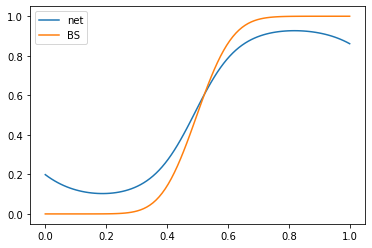

In [ ]:
model = Toy_Net1(in_feat=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
train_loss_hist = []
val_loss_hist = []
for epoch in range(num_epochs):
  train(model, device, training_loader, optimizer, epoch)
  test(model, device, testing_loader)

# visualize the final fitted delta
standard_states = np.linspace(0.0,1.0,num=100,endpoint=True).reshape(-1,1)
standard_BS_delta = delta_call_BS((S0_upper_bound-S0_lower_bound)*standard_states + 
                                  S0_lower_bound, K, T_delta, r, sigma)

model.eval()
predictions = model(torch.Tensor(standard_states))

plt.figure(2)
l1, = plt.plot(standard_states, predictions.detach().numpy())
l2, = plt.plot(standard_states, standard_BS_delta)
plt.legend(handles=[l1,l2], labels = ['net','BS'], loc='best')

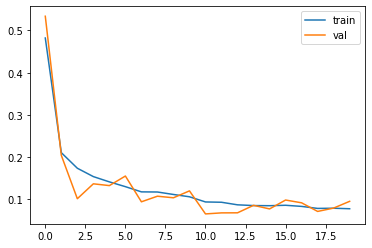

In [ ]:
plt.figure(2)
l1, = plt.plot(train_loss_hist)
l2, = plt.plot(val_loss_hist)
plt.legend(handles=[l1,l2], labels = ['train','val'], loc='best')

### try new convex loss metric (entropy)

In [ ]:
def train(model, device, training_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for idx, data in enumerate(training_loader, 0):
        inputs, S_mat, C0 = data;
    
        # Forward
        outputs = model(inputs)
        
        # Loss
        loss = entropy(outputs * (S_mat[:,1:] - S_mat[:,0:1]) + C0 - torch.max(S_mat[:,1:] - K, torch.zeros(batch_size, 1)), loss_param=2.0)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Comp grad
        loss.backward()
        
        # One step forward
        optimizer.step()
       
        total_loss += loss.item()
    
    print("Train Epoch: {}, Loss: {}".format(epoch, total_loss/len(training_loader)))
    train_loss_hist.append(total_loss/len(training_loader))

def test(model, device, testing_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for idx, data in enumerate(testing_loader, 0):
            inputs, S_mat, C0 = data;
    
            # Forward
            outputs = model(inputs)
        
            # Loss
            loss = entropy(outputs * (S_mat[:,1:] - S_mat[:,0:1]) + C0 - torch.max(S_mat[:,1:] - K, torch.zeros(batch_size, 1)), loss_param=2.0)
        
            total_loss += loss.item() 

    print("Test loss: {}".format(total_loss/len(testing_loader)))
    val_loss_hist.append(total_loss/len(testing_loader))

Train Epoch: 0, Loss: 0.26899018049240114
Test loss: 0.27721003293991087
Train Epoch: 1, Loss: 0.23189204901456834
Test loss: 0.20105238482356072
Train Epoch: 2, Loss: 0.2126232847571373
Test loss: 0.1935417905449867
Train Epoch: 3, Loss: 0.19669503405690192
Test loss: 0.17879362106323243
Train Epoch: 4, Loss: 0.18258470445871353
Test loss: 0.16837715357542038
Train Epoch: 5, Loss: 0.17925363391637802
Test loss: 0.16154943890869616
Train Epoch: 6, Loss: 0.1753153119981289
Test loss: 0.15794346444308757
Train Epoch: 7, Loss: 0.1656907592713833
Test loss: 0.16353354118764402
Train Epoch: 8, Loss: 0.164898551851511
Test loss: 0.15876214057207108
Train Epoch: 9, Loss: 0.16143428653478623
Test loss: 0.15429576858878136
Train Epoch: 10, Loss: 0.1520988454669714
Test loss: 0.15022517684847117
Train Epoch: 11, Loss: 0.1511368003487587
Test loss: 0.14750750176608562
Train Epoch: 12, Loss: 0.1659612262994051
Test loss: 0.1487760752439499
Train Epoch: 13, Loss: 0.1629078570753336
Test loss: 0.137

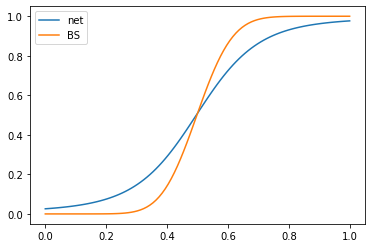

In [ ]:
model = Toy_Net1(in_feat = 1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
train_loss_hist = []
val_loss_hist = []
for epoch in range(num_epochs):
    train(model, device, training_loader, optimizer, epoch)
    test(model, device, testing_loader)

# visualize the final fitted delta
standard_states = np.linspace(0.0,1.0,num=100,endpoint=True).reshape(-1,1)
standard_BS_delta = delta_call_BS((S0_upper_bound-S0_lower_bound)*standard_states + 
                                  S0_lower_bound, K, T_delta, r, sigma)

model.eval()
predictions = model(torch.Tensor(standard_states))

plt.figure(3)
l1, = plt.plot(standard_states, predictions.detach().numpy())
l2, = plt.plot(standard_states, standard_BS_delta)
plt.legend(handles=[l1,l2], labels = ['net','BS'], loc='best')

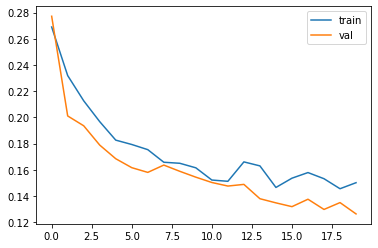

In [ ]:
plt.figure(3)
l1, = plt.plot(train_loss_hist)
l2, = plt.plot(val_loss_hist)
plt.legend(handles=[l1,l2], labels = ['train','val'], loc='best')

### try new wealth calculation and information set; with risk-free/bond investment
The new information set is the so-called log-moneyness, which is equal to the logarithmic of the ratio "S_t / Strike"

In [ ]:
def train(model, device, training_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for idx, data in enumerate(training_loader, 0):
        inputs, S_mat, C0 = data;
    
        # Forward
        outputs = model(torch.log(S_mat[:,0:1]/K))
        #outputs = model(inputs)
        
        # Loss
        # build init position, inflow the option premium, outflow the position of underlying for delta hedging
        wealth = C0 - outputs*S_mat[:,0:1]
        # liquidation
        wealth = wealth * np.exp(r*T_delta) + outputs*S_mat[:,1:] - torch.max(S_mat[:,1:]-K, torch.zeros(batch_size, 1))
        # first part is rf investment, second part is inflow of liquidation, third part is the outflow of option payoff

        loss = entropy(wealth, loss_param=2.0)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Comp grad
        loss.backward()
        
        # One step forward
        optimizer.step()
       
        total_loss += loss.item()
        
    print("Train Epoch: {}, Loss: {}".format(epoch, total_loss/len(training_loader)))
    train_loss_hist.append(total_loss/len(training_loader))

def test(model, device, testing_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for idx, data in enumerate(testing_loader, 0):
            inputs, S_mat, C0 = data;
    
            # Forward
            outputs = model(torch.log(S_mat[:,0:1]/K))
            #outputs = model(inputs)
            
            # Loss
            # build init position
            wealth = C0 - outputs*S_mat[:,0:1]
            # liquidation
            wealth = wealth * np.exp(r*T_delta) + outputs*S_mat[:,1:] - torch.max(S_mat[:,1:]-K, torch.zeros(batch_size, 1))
        
            loss = entropy(wealth, loss_param=2.0)
            
            total_loss += loss.item() 

    print("Test loss: {}".format(total_loss/len(testing_loader)))
    val_loss_hist.append(total_loss/len(testing_loader))

Train Epoch: 0, Loss: 0.2995652151107788
Test loss: 0.4938798576593399
Train Epoch: 1, Loss: 0.2119583171606064
Test loss: 0.24079692214727402
Train Epoch: 2, Loss: 0.17945936277508737
Test loss: 0.2484548419713974
Train Epoch: 3, Loss: 0.17541299171745778
Test loss: 0.1655053857713938
Train Epoch: 4, Loss: 0.16938034534454346
Test loss: 0.14163636788725853
Train Epoch: 5, Loss: 0.16522564272396267
Test loss: 0.17367390170693398
Train Epoch: 6, Loss: 0.1656823344901204
Test loss: 0.1700010508298874
Train Epoch: 7, Loss: 0.1581415306031704
Test loss: 0.1671996619552374
Train Epoch: 8, Loss: 0.16085756354033948
Test loss: 0.15470572970807553
Train Epoch: 9, Loss: 0.15221187165006994
Test loss: 0.15872296914458275
Train Epoch: 10, Loss: 0.14765032865107058
Test loss: 0.1347965208813548
Train Epoch: 11, Loss: 0.173025452978909
Test loss: 0.15216144397854806
Train Epoch: 12, Loss: 0.14640656899660826
Test loss: 0.13913829512894155
Train Epoch: 13, Loss: 0.1603078278899193
Test loss: 0.13834

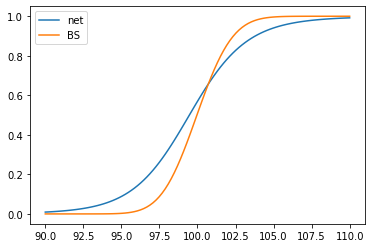

In [ ]:
model = Toy_Net1(in_feat = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.005, amsgrad=False)
train_loss_hist = []
val_loss_hist = []
for epoch in range(num_epochs):
    train(model, device, training_loader, optimizer, epoch)
    test(model, device, testing_loader)

# visualize the final fitted delta
standard_states = (S0_upper_bound-S0_lower_bound)*np.linspace(0.0,1.0,num=100,endpoint=True).reshape(-1,1) + S0_lower_bound
standard_BS_delta = delta_call_BS(standard_states, K, T_delta, r, sigma)

model.eval()
predictions = model(torch.log(torch.Tensor(standard_states/S0)))

plt.figure(4)
l1, = plt.plot(standard_states, predictions.detach().numpy())
l2, = plt.plot(standard_states, standard_BS_delta)
plt.legend(handles=[l1,l2], labels = ['net','BS'], loc='best')

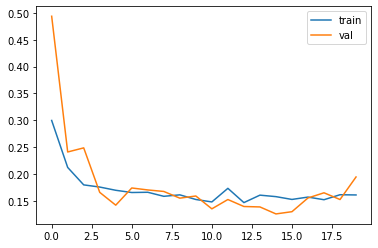

In [ ]:
plt.figure(4)
l1, = plt.plot(train_loss_hist)
l2, = plt.plot(val_loss_hist)
plt.legend(handles=[l1,l2], labels = ['train','val'], loc='best')

### Toy model 2: use a recurrent NN to do 2-step hedge; with entropy loss and bond investment.

In [ ]:
# Construct Neural Net
class Toy_Net2(nn.Module):
    
    def __init__(self, delta_constraint = None):
        super(Toy_Net2, self).__init__()

        self.delta_constraint = delta_constraint
        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=16,
            num_layers=1,
            batch_first=True,
        ) # batch_first means the input and output both make the batchsize to be the first dim 
        self.out_lin = nn.Linear(16, 1)
        self.out_sig = nn.Sigmoid()
        
    def forward(self, X):
            
        r_out, h_n = self.rnn(X, None)

        out = self.out_lin(r_out)
        out = self.out_sig(out)
        
        return out

In [ ]:
uniform_samples = np.random.rand(num_samples, 1)
S0_values = (S0_upper_bound - S0_lower_bound) * uniform_samples + S0_lower_bound
S1_values = S0_values * np.exp((r-0.5*sigma**2)*T_delta + sigma*np.sqrt(T_delta)*np.random.randn(num_samples, 1))
S2_values = S1_values * np.exp((r-0.5*sigma**2)*T_delta + sigma*np.sqrt(T_delta)*np.random.randn(num_samples, 1))
S_mat = np.hstack((S0_values, S1_values, S2_values))
call_values = price_call_BS(S0_values, K, T_delta*2, r, sigma)

training_set = torch.utils.data.TensorDataset(torch.Tensor(S_mat[:10000,:]).unsqueeze(2),
        torch.Tensor(call_values[:10000,:]))
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size,
                                              shuffle=True)


testing_set = torch.utils.data.TensorDataset(torch.Tensor(S_mat[10000:,:]).unsqueeze(2),                                      
        torch.Tensor(call_values[10000:,:]))
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size,
                                              shuffle=True)

In [ ]:
def train(model, device, training_loader, optimizer, epoch):
    model.train()
    total_loss = 0

    for idx, data in enumerate(training_loader, 0):
        S_mat, C0 = data;
    
        # 1. Forward
        outputs = model(torch.log(S_mat/K))
        
        # 2. Loss
        # build init position
        wealth = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:]
        # Wealth for the next period
        # w_{t} = w_{t-1} * exp(r*T_delta) + (strategy_{t-1}-strategy_{t})*prc_{t}
        wealth = wealth * np.exp(r*T_delta) + (outputs[:,0:1,:]-outputs[:,1:2,:])*S_mat[:,1:2,:]      
        # liquidation
        wealth = wealth * np.exp(r*T_delta) + outputs[:,-2:-1,:]*S_mat[:,-1:,:] - torch.max(S_mat[:,-1:,:] - K, torch.zeros(batch_size, 1, 1))
        
        loss = entropy(wealth, loss_param=2.0)        
        
        # 3. Zero the parameter gradients
        optimizer.zero_grad()
        
        # 4. Comp grad
        loss.backward()
        
        # 5. One step forward
        optimizer.step()
        
        total_loss += loss.item()
        
    print("Train Epoch: {}, Loss: {}".format(epoch, total_loss/len(training_loader)))
    train_loss_hist.append(total_loss/len(training_loader))

def test(model, device, testing_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for idx, data in enumerate(testing_loader, 0):
            S_mat, C0 = data;
    
            # Forward
            outputs = model(torch.log(S_mat/K))
            
            # Loss
            # build init position
            wealth = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:]
            # Wealth for the next period
            # w_{t} = w_{t-1} * exp(r*T_delta) + (strategy_{t-1}-strategy_{t})*prc_{t}
            wealth = wealth * np.exp(r*T_delta) + (outputs[:,0:1,:]-outputs[:,1:2,:])*S_mat[:,1:2,:]      
            # liquidation
            wealth = wealth * np.exp(r*T_delta) + outputs[:,-2:-1,:]*S_mat[:,-1:,:] - torch.max(S_mat[:,-1:,:] - K, torch.zeros(batch_size, 1, 1))
        
            loss = entropy(wealth, loss_param=2.0)
            
            total_loss += loss.item() 

    print("Test loss: {}".format(total_loss/len(testing_loader)))
    val_loss_hist.append(total_loss/len(testing_loader))

In [ ]:
model = Toy_Net2().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.005, amsgrad=False)
train_loss_hist = []
val_loss_hist = []
for epoch in range(num_epochs):
    train(model, device, training_loader, optimizer, epoch)
    test(model, device, testing_loader)

Train Epoch: 0, Loss: 1.3051797819137574
Test loss: 1.2008384585380554
Train Epoch: 1, Loss: 0.809730104804039
Test loss: 0.6854076087474823
Train Epoch: 2, Loss: 0.6282846558094025
Test loss: 0.3904705852270126
Train Epoch: 3, Loss: 0.4216884168982506
Test loss: 0.494970428943634
Train Epoch: 4, Loss: 0.34417362868785856
Test loss: 0.27808022052049636
Train Epoch: 5, Loss: 0.25578057900071144
Test loss: 0.20552724450826645
Train Epoch: 6, Loss: 0.2518786318600178
Test loss: 0.1805770955979824
Train Epoch: 7, Loss: 0.2492243878543377
Test loss: 0.1687289759516716
Train Epoch: 8, Loss: 0.24807477489113808
Test loss: 0.23669458031654358
Train Epoch: 9, Loss: 0.2310638517141342
Test loss: 0.16946241557598113
Train Epoch: 10, Loss: 0.2289821670949459
Test loss: 0.1916375808417797
Train Epoch: 11, Loss: 0.21415503963828086
Test loss: 0.17290788926184178
Train Epoch: 12, Loss: 0.26784187167882917
Test loss: 0.2232175998389721
Train Epoch: 13, Loss: 0.22283326119184493
Test loss: 0.2032238699

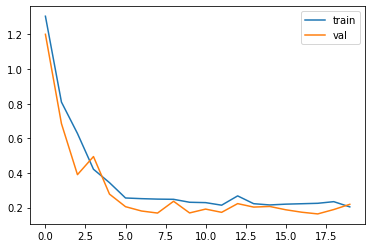

In [ ]:
plt.figure(5)
l1, = plt.plot(train_loss_hist)
l2, = plt.plot(val_loss_hist)
plt.legend(handles=[l1,l2], labels = ['train','val'], loc='best')

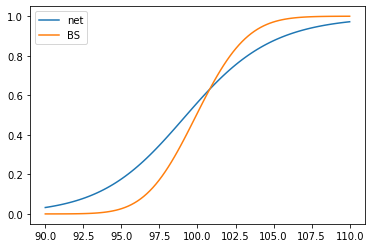

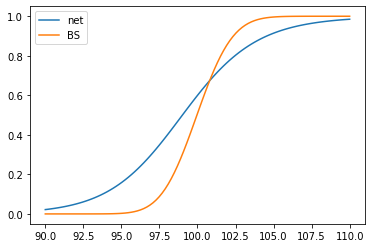

In [ ]:
# visualize the final fitted delta
standard_states = (S0_upper_bound-S0_lower_bound)*np.linspace(0.0,1.0,num=100,endpoint=True).reshape(-1,1) + S0_lower_bound

model.eval()
predictions = model(torch.log(torch.Tensor(np.tile(standard_states,(1,2))/K)).unsqueeze(2))

plt.figure()
l1, = plt.plot(standard_states, predictions.detach().numpy()[:,0,:])
l2, = plt.plot(standard_states, delta_call_BS(standard_states, K, T_delta*2, r, sigma))
plt.legend(handles=[l1,l2], labels = ['net','BS'], loc='best')

plt.figure()
l1, = plt.plot(standard_states, predictions.detach().numpy()[:,1,:])
l2, = plt.plot(standard_states, delta_call_BS(standard_states, K, T_delta, r, sigma))
plt.legend(handles=[l1,l2], labels = ['net','BS'], loc='best')

### For loop version, ready for multi-stage (>=3); with transaction cost (except in final liquidation step) and CVaR loss

In [ ]:
def train(model, device, training_loader, optimizer, epoch, tc_type = 'no', alpha = 5):
    model.train()
    total_loss = 0
    for idx, data in enumerate(training_loader, 0):
        S_mat, C0 = data;
    
        # Forward
        outputs = model(torch.log(S_mat/K))
        
        # Loss
        # build init position
        wealth = torch.zeros(size = S_mat.shape)
        if tc_type == 'no':
            wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:]
        elif tc_type == 'prop':
            wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:] - tc_ratio*torch.abs(outputs[:,0:1,:]*S_mat[:,0:1,:])
        else:
            wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:] - tc_const
        
        # Wealth for the next period
        # w_{t} = w_{t-1} * exp(r*T_delta) + (strategy_{t-1}-strategy_{t})*prc_{t}
        for t in range(1,S_mat.shape[1]-1):
            if tc_type == 'no':
                wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]      
            elif tc_type == 'prop':
                wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]-tc_ratio*torch.abs((outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:])
            else:
                wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]-tc_const
                
        # liquidation
        wealth[:,-1:,:] = wealth[:,-2:-1,:]*np.exp(r*T_delta)+outputs[:,-2:-1,:]*S_mat[:,-1:,:]-torch.max(S_mat[:,-1:,:]-K,torch.zeros(batch_size,1,1))
        
        loss = CVaR(wealth[:,-1:,:], alpha)
        # loss = torch.mean(-wealth[:, -1,:])
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Comp grad
        loss.backward()
        
        # One step forward
        optimizer.step()
        
        total_loss += loss.item()
        
    print("Train Epoch: {}, Loss: {}".format(epoch, total_loss/len(training_loader)))
    train_loss_hist.append(total_loss/len(training_loader))

def test(model, device, testing_loader, tc_type = 'no', alpha = 5):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for idx, data in enumerate(testing_loader, 0):
            S_mat, C0 = data;
    
            # Forward
            outputs = model(torch.log(S_mat/K))
            
            # Loss
            # build init position
            wealth = torch.zeros(size = S_mat.shape)
            if tc_type == 'no':
                wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:]
            elif tc_type == 'prop':
                wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:] - tc_ratio*torch.abs(outputs[:,0:1,:]*S_mat[:,0:1,:])
            else:
                wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:] - tc_const
        
            # Wealth for the next period
            # w_{t} = w_{t-1} * exp(r*T_delta) + (strategy_{t-1}-strategy_{t})*prc_{t}
            for t in range(1,S_mat.shape[1]-1):
                if tc_type == 'no':
                    wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]      
                elif tc_type == 'prop':
                    wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]-tc_ratio*torch.abs((outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:])
                else:
                    wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]-tc_const
            
            # liquidation
            wealth[:,-1:,:] = wealth[:,-2:-1,:]*np.exp(r*T_delta)+outputs[:,-2:-1,:]*S_mat[:,-1:,:]-torch.max(S_mat[:,-1:,:]-K,torch.zeros(batch_size,1,1))
        
            loss = CVaR(wealth[:,-1:,:], alpha)  

            total_loss += loss.item() 

    print("Test loss: {}".format(total_loss/len(testing_loader)))
    val_loss_hist.append(total_loss/len(testing_loader))

### no transcation cost

In [ ]:
model = Toy_Net2().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-06, weight_decay=0.01, amsgrad=False)
train_loss_hist = []
val_loss_hist = []
for epoch in range(num_epochs):
    train(model, device, training_loader, optimizer, epoch, 'no')
    test(model, device, testing_loader, 'no')

Train Epoch: 0, Loss: 2.4827477741241455
Test loss: 2.427676272392273
Train Epoch: 1, Loss: 1.860217843055725
Test loss: 1.4278134107589722
Train Epoch: 2, Loss: 1.3489011216163636
Test loss: 1.2132427453994752
Train Epoch: 3, Loss: 1.1882612490653992
Test loss: 1.1042995274066925
Train Epoch: 4, Loss: 1.0797444880008698
Test loss: 0.9770581901073456
Train Epoch: 5, Loss: 1.031769894361496
Test loss: 0.9612403690814972
Train Epoch: 6, Loss: 1.005151835680008
Test loss: 0.928548389673233
Train Epoch: 7, Loss: 1.0194589221477508
Test loss: 0.9152933061122894
Train Epoch: 8, Loss: 1.0152523767948152
Test loss: 0.9312253415584564
Train Epoch: 9, Loss: 1.0537881231307984
Test loss: 0.9082442462444306
Train Epoch: 10, Loss: 1.0308067679405213
Test loss: 0.927177619934082
Train Epoch: 11, Loss: 1.1292904376983643
Test loss: 0.9690411925315857
Train Epoch: 12, Loss: 0.9987395429611206
Test loss: 1.0150588393211364
Train Epoch: 13, Loss: 1.0080337584018708
Test loss: 0.9143038809299469
Train Ep

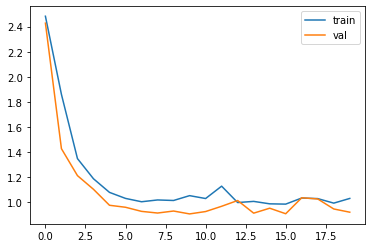

In [ ]:
plt.figure(6)
l1, = plt.plot(train_loss_hist)
l2, = plt.plot(val_loss_hist)
plt.legend(handles=[l1,l2], labels = ['train','val'], loc='best')

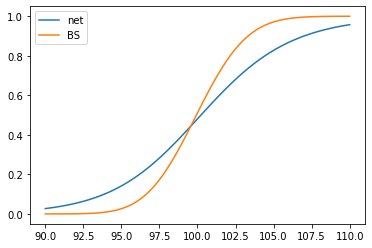

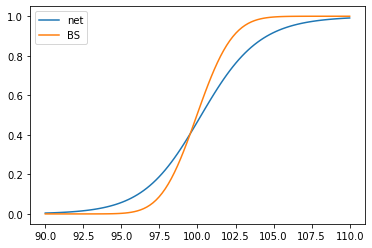

In [ ]:
# visualize the final fitted delta
standard_states = (S0_upper_bound-S0_lower_bound)*np.linspace(0.0,1.0,num=100,endpoint=True).reshape(-1,1) + S0_lower_bound

model.eval()
predictions = model(torch.log(torch.Tensor(np.tile(standard_states,(1,2))/K)).unsqueeze(2))

plt.figure()
l1, = plt.plot(standard_states, predictions.detach().numpy()[:,0,:])
l2, = plt.plot(standard_states, delta_call_BS(standard_states, K, T_delta*2, r, sigma))
plt.legend(handles=[l1,l2], labels = ['net','BS'], loc='best')

plt.figure()
l1, = plt.plot(standard_states, predictions.detach().numpy()[:,1,:])
l2, = plt.plot(standard_states, delta_call_BS(standard_states, K, T_delta, r, sigma))
plt.legend(handles=[l1,l2], labels = ['net','BS'], loc='best')

### Conclusion1:
Based on the above delta comparsion in one-step and two-step hedge, we could see the NN delta change in a slower speed than the BS delta (i.e. a less second-order derivative: Gamma).The NN delta will cross over with the BS delta around the forward at-the-money level (aka. fwd ATM). For those deep OTM or ITM areas, the NN will produce a more mordate delta which is closer to the 0.5 point. When we increase the regularized level (more strong weight decay), the curvature will be further increased, which is consistent with our intuitions.

All in all, the NN delta still demonstrate similar pattern as the BS framework: as time to maturity decreases, the curvature/gamma will increase.

### Policy Search: 3-step hedge using a well-designed strategy network.
if using tanh as activation function, we have to enforce delta constraint [0, 1]

In [ ]:
# Construct Neural Net
class Strategy_Net(nn.Module):
    
    def __init__(self, m = None, actv = 'Sigmoid'):
        super(Strategy_Net, self).__init__()
        self.actv = actv
        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=m,
            num_layers=1,
            batch_first=True,
        )
        self.out_lin = nn.Linear(m, 1)
        if self.actv == 'tanh':
            self.out_actv = nn.Tanh()
        else:
            self.out_actv = nn.Sigmoid()
        
        
    def forward(self, X):
            
        r_out, h_n = self.rnn(X, None)

        out = self.out_lin(r_out)
        out = self.out_actv(out)
        if self.actv == 'tanh':
            out = 0.5 * (out - (-1))
        
        return out

### Test/BS PnL Visualization helper

In [ ]:
def BS_PnL(testing_loader, tc_type = 'no'):
    #model.eval()
    PnL = np.zeros((len(testing_loader)*batch_size,1))
    
    with torch.no_grad():
        for idx, data in enumerate(testing_loader, 0):
            S_mat, C0 = data;
            S_mat = torch.squeeze(S_mat).detach().numpy()
            C0 = C0.detach().numpy()
            T = S_mat.shape[1] # from time 0 to epiration date
            
            
            # build init position
            wealth = np.zeros(shape = S_mat.shape)
            if tc_type == 'no':
                wealth[:,0:1] = C0 - delta_call_BS(S_mat[:, 0:1], K, T_delta*(T-1), r, sigma)*S_mat[:,0:1]
            elif tc_type == 'prop':
                wealth[:,0:1] = C0 - delta_call_BS(S_mat[:, 0:1], K, T_delta*(T-1), r, sigma)*S_mat[:,0:1] - tc_ratio*np.abs(delta_call_BS(S_mat[:, 0:1], K, T_delta*(T-1), r, sigma)*S_mat[:,0:1])
            else:
                wealth[:,0:1] = C0 - delta_call_BS(S_mat[:, 0:1], K, T_delta*(T-1), r, sigma)*S_mat[:,0:1] - tc_const
            
            # Wealth for the next period
            # w_{t} = w_{t-1} * exp(r*T_delta) + (strategy_{t-1}-strategy_{t})*prc_{t}
            for t in range(1,S_mat.shape[1]-1):
                if tc_type == 'no':
                    wealth[:,t:t+1] = wealth[:,t-1:t]*np.exp(r*T_delta)+(delta_call_BS(S_mat[:, t-1:t], K, T_delta*(T-1-t), r, sigma)-delta_call_BS(S_mat[:, t: t+1], K, T_delta*(T-2-t), r, sigma))*S_mat[:,t:t+1]
                elif tc_type == 'prop':
                    wealth[:,t:t+1] = wealth[:,t-1:t]*np.exp(r*T_delta)+(delta_call_BS(S_mat[:, t-1:t], K, T_delta*(T-1-t), r, sigma)-delta_call_BS(S_mat[:, t: t+1], K, T_delta*(T-2-t), r, sigma))*S_mat[:,t:t+1]-tc_ratio*np.abs((delta_call_BS(S_mat[:, t-1:t], K, T_delta*(T-1-t), r, sigma)-delta_call_BS(S_mat[:, t: t+1], K, T_delta*(T-2-t), r, sigma))*S_mat[:,t:t+1])
                else:
                    wealth[:,t:t+1] = wealth[:,t-1:t]*np.exp(r*T_delta)+(delta_call_BS(S_mat[:, t-1:t], K, T_delta*(T-1-t), r, sigma)-delta_call_BS(S_mat[:, t: t+1], K, T_delta*(T-2-t), r, sigma))*S_mat[:,t:t+1]-tc_const

            # liquidation
            wealth[:,-1:] = wealth[:,-2:-1]*np.exp(r*T_delta)+delta_call_BS(S_mat[:, -2:-1], K, T_delta, r, sigma)*S_mat[:,-1:]-np.maximum(S_mat[:,-1:]-K, np.zeros((batch_size,1)))
        
            PnL[idx*batch_size:(idx+1)*batch_size] =  wealth[:,-1:]
    
    return PnL


In [ ]:
def test_PnL(model, device, testing_loader, tc_type = 'no'):
    model.eval()
    PnL = torch.zeros(len(testing_loader)*batch_size)
    
    with torch.no_grad():
        for idx, data in enumerate(testing_loader, 0):
            S_mat, C0 = data;
    
            # Forward
            outputs = model(torch.log(S_mat/K))  
            
            # build init position
            wealth = torch.zeros(size = S_mat.shape)
            if tc_type == 'no':
                wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:]
            elif tc_type == 'prop':
                wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:] - tc_ratio*torch.abs(outputs[:,0:1,:]*S_mat[:,0:1,:])
            else:
                wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:] - tc_const
            
            # Wealth for the next period
            # w_{t} = w_{t-1} * exp(r*T_delta) + (strategy_{t-1}-strategy_{t})*prc_{t}
            for t in range(1,S_mat.shape[1]-1):
                if tc_type == 'no':
                    wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]
                elif tc_type == 'prop':
                    wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]-tc_ratio*torch.abs((outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:])
                else:
                    wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]-tc_const
                    
            # liquidation
            wealth[:,-1:,:] = wealth[:,-2:-1,:]*np.exp(r*T_delta)+outputs[:,-2:-1,:]*S_mat[:,-1:,:]-torch.max(S_mat[:,-1:,:]-K,torch.zeros(batch_size,1,1))
        
            PnL[idx*batch_size:(idx+1)*batch_size] =  torch.squeeze(wealth[:,-1:,:])
    
    return PnL

In [ ]:
uniform_samples = np.random.rand(num_samples, 1)
S0_values = (S0_upper_bound - S0_lower_bound) * uniform_samples + S0_lower_bound
S1_values = S0_values * np.exp((r-0.5*sigma**2)*T_delta + sigma*np.sqrt(T_delta)*np.random.randn(num_samples, 1))
S2_values = S1_values * np.exp((r-0.5*sigma**2)*T_delta + sigma*np.sqrt(T_delta)*np.random.randn(num_samples, 1))
S3_values = S2_values * np.exp((r-0.5*sigma**2)*T_delta + sigma*np.sqrt(T_delta)*np.random.randn(num_samples, 1))

S_mat = np.hstack((S0_values, S1_values, S2_values, S3_values))
call_values = price_call_BS(S0_values, K, T_delta*3, r, sigma)

training_set = torch.utils.data.TensorDataset(torch.Tensor(S_mat[:10000,:]).unsqueeze(2),
        torch.Tensor(call_values[:10000,:]))
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size,
                                              shuffle=True)


testing_set = torch.utils.data.TensorDataset(torch.Tensor(S_mat[10000:,:]).unsqueeze(2),                                      
        torch.Tensor(call_values[10000:,:]))
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size,
                                              shuffle=True)

### prop tc

In [ ]:
model = Strategy_Net(m = 20, actv = 'tanh').to(device) # model has to be uploaded to GPU after instantiation
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-06, weight_decay=0.01, amsgrad=False)
# accumulated grad and grad-square has to been kept about 0.9 and 0.999 from previous step respectively
train_loss_hist = []
val_loss_hist = []
for epoch in range(num_epochs):
    train(model, device, training_loader, optimizer, epoch, 'prop', alpha = 5)
    test(model, device, testing_loader, 'prop', alpha = 5)

Train Epoch: 0, Loss: 3.214535894393921
Test loss: 2.494934391975403
Train Epoch: 1, Loss: 2.1010505604743956
Test loss: 1.723454487323761
Train Epoch: 2, Loss: 1.7281522631645203
Test loss: 1.5187169790267945
Train Epoch: 3, Loss: 1.5237973356246948
Test loss: 1.5031157851219177
Train Epoch: 4, Loss: 1.4999212551116943
Test loss: 1.4598969221115112
Train Epoch: 5, Loss: 1.4834429979324342
Test loss: 1.638926088809967
Train Epoch: 6, Loss: 1.489424078464508
Test loss: 1.4790139198303223
Train Epoch: 7, Loss: 1.5076704168319701
Test loss: 1.7487450003623963
Train Epoch: 8, Loss: 1.6481852674484252
Test loss: 1.5268455147743225
Train Epoch: 9, Loss: 1.514493408203125
Test loss: 1.5113330721855163
Train Epoch: 10, Loss: 1.4702888679504396
Test loss: 1.5194690823554993
Train Epoch: 11, Loss: 1.479324369430542
Test loss: 1.4859724998474122
Train Epoch: 12, Loss: 1.490663194656372
Test loss: 1.4765835762023927
Train Epoch: 13, Loss: 1.5441766428947448
Test loss: 1.4984431862831116
Train Epoc

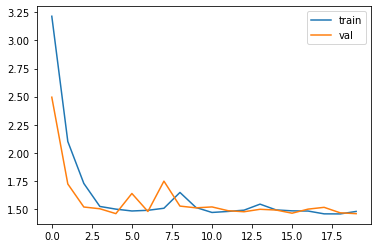

In [ ]:
plt.figure(7)
l1, = plt.plot(train_loss_hist)
l2, = plt.plot(val_loss_hist)
plt.legend(handles=[l1,l2], labels = ['train','val'], loc='best')

In [ ]:
# store delta
standard_states = (S0_upper_bound-S0_lower_bound)*np.linspace(0.0,1.0,num=100,endpoint=True).reshape(-1,1) + S0_lower_bound

model.eval()
predictions_prop = model(torch.log(torch.Tensor(np.tile(standard_states,(1,3))/K)).unsqueeze(2))

In [ ]:
res_prop = test_PnL(model, device, testing_loader, 'prop')

### fix tc.

In [ ]:
model = Strategy_Net(m = 20, actv = 'tanh').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-06, weight_decay=0.01, amsgrad=False) # amsgrad: boolean. if use the refined version called AMSGrad
train_loss_hist = []
val_loss_hist = []
for epoch in range(num_epochs):
    train(model, device, training_loader, optimizer, epoch, 'fix', alpha = 5) # the tc type is a para for the train and test funcs, since it is used in the calculation of wealth and reward function
    test(model, device, testing_loader, 'fix', alpha = 5)

Train Epoch: 0, Loss: 3.3565691471099854
Test loss: 2.4595529556274416
Train Epoch: 1, Loss: 2.3718624615669253
Test loss: 2.12366703748703
Train Epoch: 2, Loss: 2.023666181564331
Test loss: 1.8501524925231934
Train Epoch: 3, Loss: 1.8736543893814086
Test loss: 1.7943923711776733
Train Epoch: 4, Loss: 1.8128796410560608
Test loss: 1.8230103373527526
Train Epoch: 5, Loss: 1.7778560996055603
Test loss: 1.7390612363815308
Train Epoch: 6, Loss: 1.8415824270248413
Test loss: 1.7613115906715393
Train Epoch: 7, Loss: 1.804650309085846
Test loss: 1.7764745235443116
Train Epoch: 8, Loss: 1.7745217990875244
Test loss: 1.7607769131660462
Train Epoch: 9, Loss: 1.7839632439613342
Test loss: 1.8263132333755494
Train Epoch: 10, Loss: 1.7712976241111755
Test loss: 1.7596596121788024
Train Epoch: 11, Loss: 1.7985441398620605
Test loss: 1.7977986454963684
Train Epoch: 12, Loss: 1.8355028796195985
Test loss: 1.9959115624427795
Train Epoch: 13, Loss: 1.7800750708580018
Test loss: 1.7692119240760804
Train 

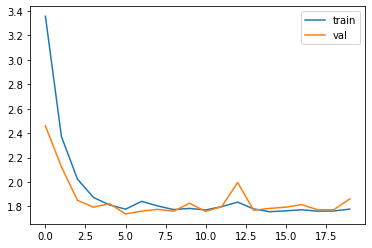

In [ ]:
plt.figure(8)
l1, = plt.plot(train_loss_hist)
l2, = plt.plot(val_loss_hist)
plt.legend(handles=[l1,l2], labels = ['train','val'], loc='best')

In [ ]:
# store delta
standard_states = (S0_upper_bound-S0_lower_bound)*np.linspace(0.0,1.0,num=100,endpoint=True).reshape(-1,1) + S0_lower_bound

model.eval()
predictions_fix = model(torch.log(torch.Tensor(np.tile(standard_states,(1,3))/K)).unsqueeze(2))

In [ ]:
res_fix = test_PnL(model, device, testing_loader, 'fix')

### Delta comparsion between proportion and fixed cost in the deep hedging

Text(0.5, 1.0, 'Third Peirod')

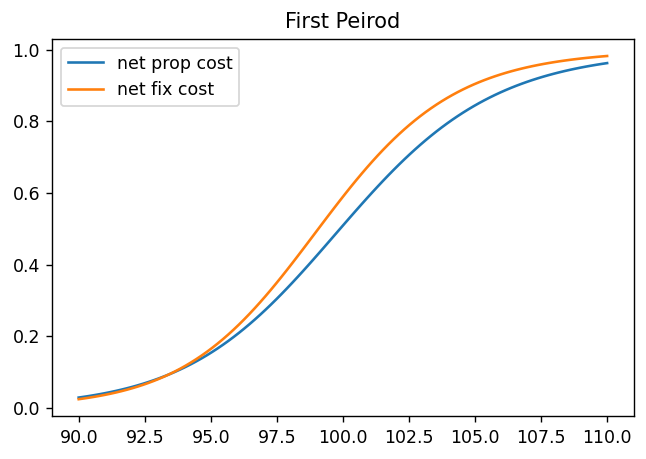

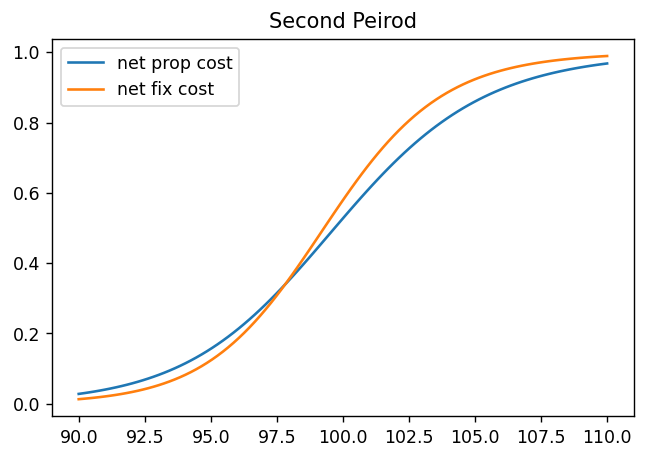

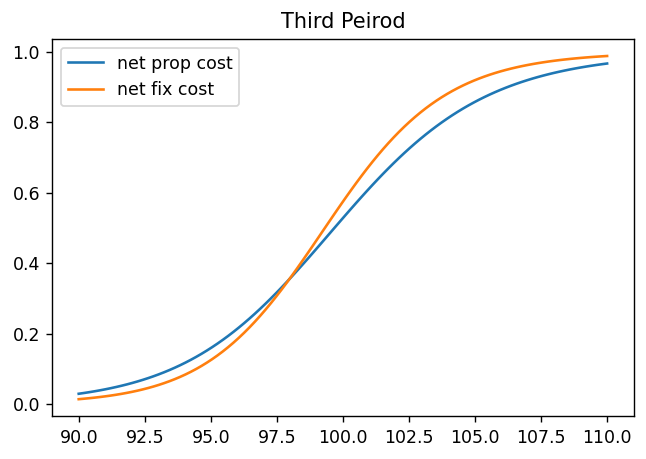

In [ ]:
plt.figure(dpi = 125)
l1, = plt.plot(standard_states, predictions_prop.detach().numpy()[:,0,:])
l2, = plt.plot(standard_states, predictions_fix.detach().numpy()[:,0,:])
plt.legend(handles=[l1,l2], labels = ['net prop cost','net fix cost'], loc='best')
plt.title('First Peirod')

plt.figure(dpi = 125)
l1, = plt.plot(standard_states, predictions_prop.detach().numpy()[:,1,:])
l2, = plt.plot(standard_states, predictions_fix.detach().numpy()[:,1,:])
plt.legend(handles=[l1,l2], labels = ['net prop cost','net fix cost'], loc='best')
plt.title('Second Peirod')

plt.figure(dpi = 125)
l1, = plt.plot(standard_states, predictions_prop.detach().numpy()[:,2,:])
l2, = plt.plot(standard_states, predictions_fix.detach().numpy()[:,2,:])
plt.legend(handles=[l1,l2], labels = ['net prop cost','net fix cost'], loc='best')
plt.title('Third Peirod')

### Conclusion2:
As shown in the above NN delta with different types of transcation costs, we could sense how the network choose optimal weights confronted with different market friction patterns. In the first stage, the NN delta with proportion cost is slightly larger than the NN delta with fixed cost around OTM area, than is exceeded by the latter one as the underlying moves towards ITM direction. This shows that the network could automatically reduce our position changes as the bet size increases in the proportion cost setting.
Due to the parameter setting of the fixed cost case, it average NN delta is larger than the proportion cost case.

As shown in the below PnL comparsion, we could see a significantly right-shifted PnL distribution in the proportion cost case. This especially validates the power of NN in dealing with "linear" market frictions.

In terms of the performance comparsion with B-S, we could see the NN PnL are more centered, which means thinner left and right tails. This is one of the mosr desired results of market makers or big investment banks.

### PnL comparsion between proportion and fixed cost in the deep hedging.

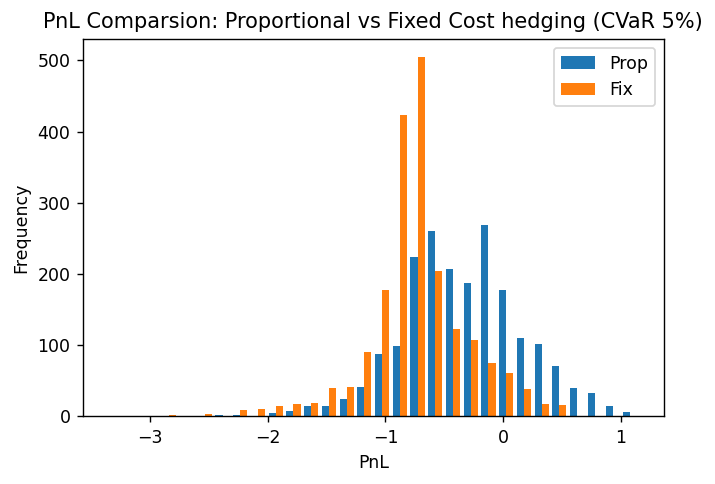

In [ ]:
comparison_plot_0 = plt.figure(dpi = 125, facecolor = 'white')
ax = comparison_plot_0.add_subplot()
ax.set_title('PnL Comparsion: Proportional vs Fixed Cost hedging (CVaR 5%)')
ax.hist((res_prop.detach().numpy(), res_fix.detach().numpy()), bins = 30, label=['Prop', 'Fix'])
ax.set_xlabel('PnL')
ax.set_ylabel('Frequency')
ax.legend()

In [ ]:
res_prop_bs = BS_PnL(testing_loader, 'prop')
res_fix_bs = BS_PnL(testing_loader, 'fix')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


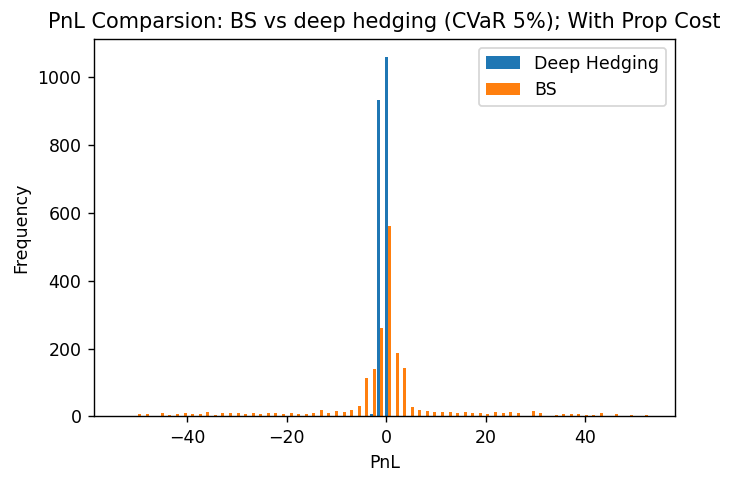

In [ ]:
comparison_plot_1 = plt.figure(dpi = 125, facecolor = 'w')
ax = comparison_plot_1.add_subplot()
ax.set_title('PnL Comparsion: BS vs deep hedging (CVaR 5%); With Prop Cost')
ax.hist((res_prop.detach().numpy(), res_prop_bs.squeeze()), bins = 70, label=['Deep Hedging', 'BS'])
ax.set_xlabel('PnL')
ax.set_ylabel('Frequency')
ax.legend()

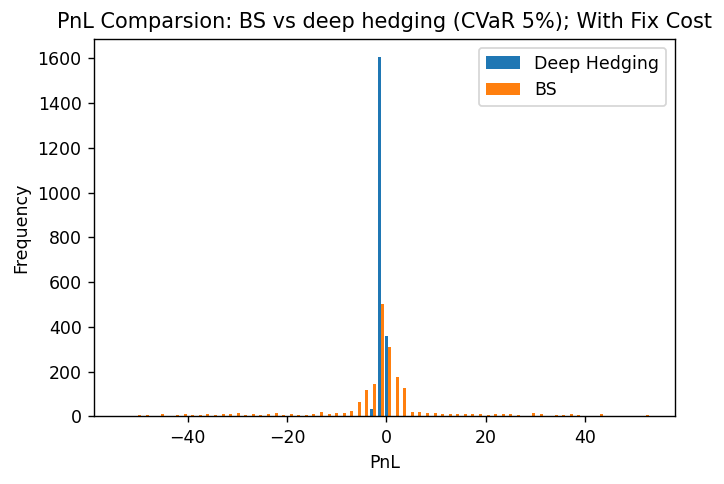

In [ ]:
comparison_plot_2 = plt.figure(dpi = 125, facecolor = 'w')
ax = comparison_plot_2.add_subplot()
ax.set_title('PnL Comparsion: BS vs deep hedging (CVaR 5%); With Fix Cost')
ax.hist((res_fix.detach().numpy(), res_fix_bs.squeeze()), bins = 70, label=['Deep Hedging', 'BS'])
ax.set_xlabel('PnL')
ax.set_ylabel('Frequency')
ax.legend()

### Policy Search: one-month daily hedge (22-step)

In [ ]:
# Simu Parameters
S0 = 100
K1 = 100
K2 = 105
T = 1/12 # one month
T_delta = T/22
r = 0.05
sigma = 0.3
num_samples = 12000
num_epochs  = 30
batch_size = 200
S0_lower_bound = 90
S0_upper_bound = 110
tc_ratio = 0.005 # proportion tc 
tc_const = S0 * 0.5 * tc_ratio # fixed tc

### first, test european call with strike K1

In [ ]:
uniform_samples = np.random.rand(num_samples, 1)
S_mat = np.zeros((num_samples, 23))
S_mat[:,0:1] = (S0_upper_bound - S0_lower_bound) * uniform_samples + S0_lower_bound
for t in range(1, 23):
    S_mat[:,t:t+1] = S_mat[:,t-1:t] * np.exp((r-0.5*sigma**2)*T_delta + sigma*np.sqrt(T_delta)*np.random.randn(num_samples, 1))

In [ ]:
call_values = price_call_BS(S0_values, K1, T, r, sigma)
spread_values = price_call_spread(S0_values, K1, K2, T, r, sigma)

training_set = torch.utils.data.TensorDataset(torch.Tensor(S_mat[:10000,:]).unsqueeze(2),
        torch.Tensor(call_values[:10000,:]))
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

testing_set = torch.utils.data.TensorDataset(torch.Tensor(S_mat[10000:,:]).unsqueeze(2),                                      
        torch.Tensor(call_values[10000:,:]))
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size, shuffle=True)

### fix cost for all following single euro call experiments, CVaR with 3%, 10% 30% risk averse levels

In [ ]:
model = Strategy_Net(m = 20, actv = 'tanh').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
train_loss_hist = []
val_loss_hist = []
for epoch in range(num_epochs):
    train(model, device, training_loader, optimizer, epoch, 'fix', alpha = 3)
    test(model, device, testing_loader, 'fix', alpha = 3)

Train Epoch: 0, Loss: 16.53945816040039
Test loss: 15.611573886871337
Train Epoch: 1, Loss: 15.111636219024659
Test loss: 15.047589683532715
Train Epoch: 2, Loss: 14.920266456604004
Test loss: 15.167467975616455
Train Epoch: 3, Loss: 14.995595092773437
Test loss: 14.757413768768311
Train Epoch: 4, Loss: 14.86174783706665
Test loss: 14.821052074432373
Train Epoch: 5, Loss: 14.835717391967773
Test loss: 14.582960605621338
Train Epoch: 6, Loss: 14.72071252822876
Test loss: 14.758867073059083
Train Epoch: 7, Loss: 14.864188137054443
Test loss: 14.802570247650147
Train Epoch: 8, Loss: 14.765989742279054
Test loss: 14.728165817260741
Train Epoch: 9, Loss: 14.685182819366455
Test loss: 14.695112800598144
Train Epoch: 10, Loss: 14.77951494216919
Test loss: 14.819642925262452
Train Epoch: 11, Loss: 14.776202354431152
Test loss: 14.71237154006958
Train Epoch: 12, Loss: 14.75701955795288
Test loss: 14.691080284118652
Train Epoch: 13, Loss: 14.759533462524415
Test loss: 14.661448955535889
Train Ep

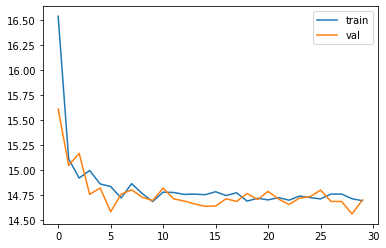

In [ ]:
plt.figure(9)
l1, = plt.plot(train_loss_hist)
l2, = plt.plot(val_loss_hist)
plt.legend(handles=[l1,l2], labels = ['train','val'], loc='best')

In [ ]:
res_fix_3 = test_PnL(model, device, testing_loader, 'fix')

In [ ]:
model = Strategy_Net(m = 20, actv = 'tanh').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
train_loss_hist = []
val_loss_hist = []
for epoch in range(num_epochs):
    train(model, device, training_loader, optimizer, epoch, 'fix', alpha = 10)
    test(model, device, testing_loader, 'fix', alpha = 10)

Train Epoch: 0, Loss: 14.641444797515868
Test loss: 14.10079050064087
Train Epoch: 1, Loss: 13.507228202819825
Test loss: 13.482854175567628
Train Epoch: 2, Loss: 13.335184268951416
Test loss: 13.344059181213378
Train Epoch: 3, Loss: 13.29138116836548
Test loss: 13.37890329360962
Train Epoch: 4, Loss: 13.279184226989747
Test loss: 13.333467388153077
Train Epoch: 5, Loss: 13.25642780303955
Test loss: 13.331296730041505
Train Epoch: 6, Loss: 13.249809055328369
Test loss: 13.391045379638673
Train Epoch: 7, Loss: 13.271474838256836
Test loss: 13.325395393371583
Train Epoch: 8, Loss: 13.225409774780273
Test loss: 13.366972732543946
Train Epoch: 9, Loss: 13.242007007598877
Test loss: 13.281430625915528
Train Epoch: 10, Loss: 13.241324253082276
Test loss: 13.27525691986084
Train Epoch: 11, Loss: 13.226826267242432
Test loss: 13.26784439086914
Train Epoch: 12, Loss: 13.224329986572265
Test loss: 13.416361904144287
Train Epoch: 13, Loss: 13.22989538192749
Test loss: 13.255270099639892
Train Epo

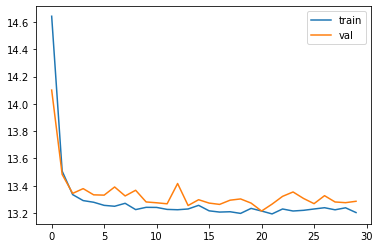

In [ ]:
plt.figure(10)
l1, = plt.plot(train_loss_hist)
l2, = plt.plot(val_loss_hist)
plt.legend(handles=[l1,l2], labels = ['train','val'], loc='best')

In [ ]:
res_fix_10 = test_PnL(model, device, testing_loader, 'fix')

In [ ]:
model = Strategy_Net(m = 20, actv = 'tanh').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
train_loss_hist = []
val_loss_hist = []
for epoch in range(num_epochs):
    train(model, device, training_loader, optimizer, epoch, 'fix', alpha = 30)
    test(model, device, testing_loader, 'fix', alpha = 30)

Train Epoch: 0, Loss: 11.472096366882324
Test loss: 11.05614013671875
Train Epoch: 1, Loss: 10.907087268829345
Test loss: 10.890986919403076
Train Epoch: 2, Loss: 10.845815391540528
Test loss: 10.904413509368897
Train Epoch: 3, Loss: 10.824505519866943
Test loss: 10.8485764503479
Train Epoch: 4, Loss: 10.825067634582519
Test loss: 10.88234348297119
Train Epoch: 5, Loss: 10.808529720306396
Test loss: 10.847157382965088
Train Epoch: 6, Loss: 10.826853561401368
Test loss: 10.885401058197022
Train Epoch: 7, Loss: 10.827388801574706
Test loss: 10.853748035430907
Train Epoch: 8, Loss: 10.79292797088623
Test loss: 10.867796516418457
Train Epoch: 9, Loss: 10.808848209381104
Test loss: 11.057976531982423
Train Epoch: 10, Loss: 10.815799732208252
Test loss: 10.85363130569458
Train Epoch: 11, Loss: 10.794725856781007
Test loss: 10.872020149230957
Train Epoch: 12, Loss: 10.784717445373536
Test loss: 10.896648693084718
Train Epoch: 13, Loss: 10.792602920532227
Test loss: 10.889049243927001
Train Ep

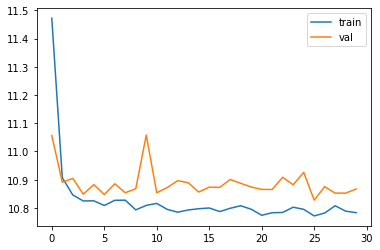

In [ ]:
plt.figure(11)
l1, = plt.plot(train_loss_hist)
l2, = plt.plot(val_loss_hist)
plt.legend(handles=[l1,l2], labels = ['train','val'], loc='best')

In [ ]:
res_fix_30 = test_PnL(model, device, testing_loader, 'fix')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


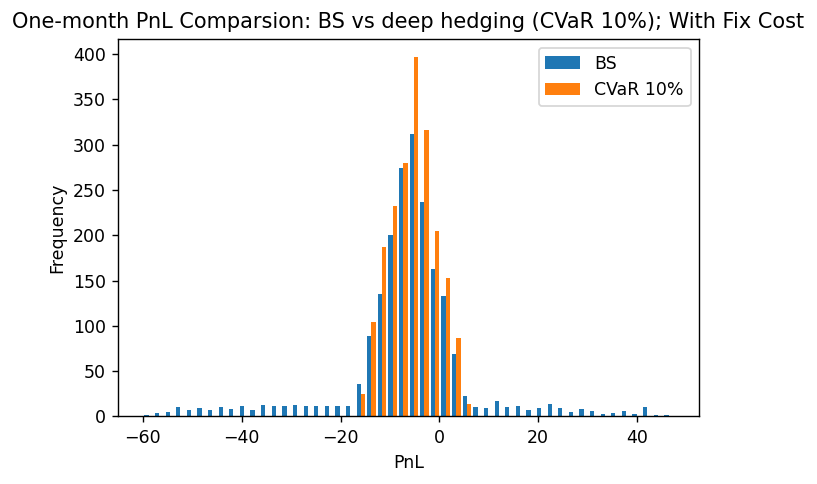

In [ ]:
res_fix_bs = BS_PnL(testing_loader, 'fix')
comparison_plot_3 = plt.figure(dpi = 125, facecolor = 'w')
ax = comparison_plot_3.add_subplot()
ax.set_title('One-month PnL Comparsion: BS vs deep hedging (CVaR 10%); With Fix Cost')
ax.hist((res_fix_bs.squeeze(), res_fix_10.detach().numpy()), bins = 50, label=['BS','CVaR 10%'])
ax.set_xlabel('PnL')
ax.set_ylabel('Frequency')
ax.legend()

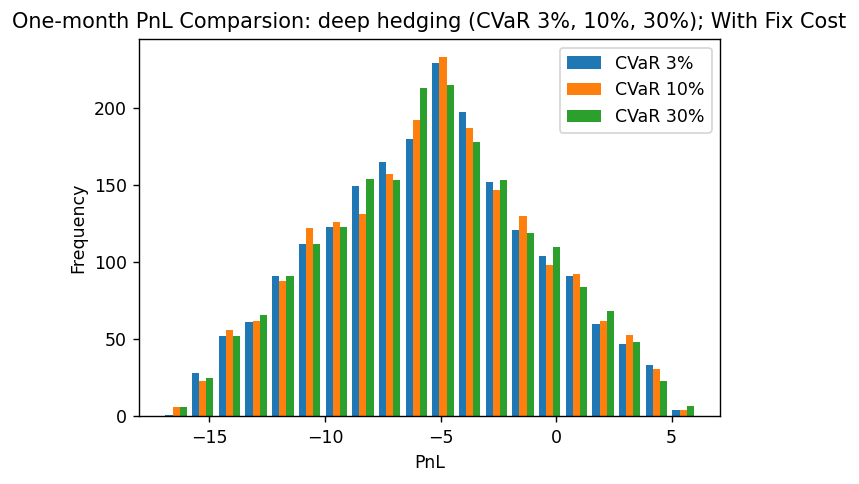

In [ ]:
comparison_plot_4 = plt.figure(dpi = 125, facecolor = 'w')
ax = comparison_plot_4.add_subplot()
ax.set_title('One-month PnL Comparsion: deep hedging (CVaR 3%, 10%, 30%); With Fix Cost')
ax.hist((res_fix_3.detach().numpy(), res_fix_10.detach().numpy(), res_fix_30.detach().numpy()), bins = 20, label=['CVaR 3%','CVaR 10%','CVaR 30%'])
ax.set_xlabel('PnL')
ax.set_ylabel('Frequency')
ax.legend()

### Conclusion3:
In our one-month hedging experiments for single options, we set the type of cost as "fixed", then tune the risk-averse parameter to examine the PnL patterns.In comparsion with the B-S PnL, we could see the NN CVaR 10% is more centered towards its mean, at the same time, its right half of the whole distribution is magnified than the left half. When exploring the effects of different risk-averse levels, we could see as the level increase (from 3% to 30%), we care more components of the entire pool, so the resulted right half of the distribution will be maginfied. However, this effect is not significant than their comparsion with B-S PnL. 

### secondly, test call spread with strike K1 and K2

In [ ]:
training_set = torch.utils.data.TensorDataset(torch.Tensor(S_mat[:10000,:]).unsqueeze(2),
        torch.Tensor(spread_values[:10000,:]))
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size,
                                              shuffle=True)


testing_set = torch.utils.data.TensorDataset(torch.Tensor(S_mat[10000:,:]).unsqueeze(2),                                      
        torch.Tensor(spread_values[10000:,:]))
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size,
                                              shuffle=True)

In [ ]:
def train_spread(model, device, training_loader, optimizer, epoch, tc_type = 'no', alpha = 5):
    model.train()
    total_loss = 0
    for idx, data in enumerate(training_loader, 0):
        S_mat, C0 = data;
    
        # Forward
        outputs = model(torch.log(S_mat/K1))
        
        # Loss
        # build init position
        wealth = torch.zeros(size = S_mat.shape)
        if tc_type == 'no':
            wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:]
        elif tc_type == 'prop':
            wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:] - tc_ratio*torch.abs(outputs[:,0:1,:]*S_mat[:,0:1,:])
        else:
            wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:] - tc_const
        
        # Wealth for the next period
        # w_{t} = w_{t-1} * exp(r*T_delta) + (strategy_{t-1}-strategy_{t})*prc_{t}
        for t in range(1,S_mat.shape[1]-1):
            if tc_type == 'no':
                wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]      
            elif tc_type == 'prop':
                wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]-tc_ratio*torch.abs((outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:])
            else:
                wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]-tc_const
                
        # liquidation
        wealth[:,-1:,:] = wealth[:,-2:-1,:]*np.exp(r*T_delta)+outputs[:,-2:-1,:]*S_mat[:,-1:,:]-torch.max(S_mat[:,-1:,:]-K1,torch.zeros(batch_size,1,1))+torch.max(S_mat[:,-1:,:]-K2,torch.zeros(batch_size,1,1))
        
        loss = CVaR(wealth[:,-1:,:], alpha)
        # loss = torch.mean(-wealth[:, -1,:])
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Comp grad
        loss.backward()
        
        # One step forward
        optimizer.step()
        
        total_loss += loss.item()
        
    print("Train Epoch: {}, Loss: {}".format(epoch, total_loss/len(training_loader)))
    train_loss_hist.append(total_loss/len(training_loader))

def test_spread(model, device, testing_loader, tc_type = 'no', alpha = 5):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for idx, data in enumerate(testing_loader, 0):
            S_mat, C0 = data;
    
            # Forward
            outputs = model(torch.log(S_mat/K1))
            
            # Loss
            # build init position
            wealth = torch.zeros(size = S_mat.shape)
            if tc_type == 'no':
                wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:]
            elif tc_type == 'prop':
                wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:] - tc_ratio*torch.abs(outputs[:,0:1,:]*S_mat[:,0:1,:])
            else:
                wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:] - tc_const
        
            # Wealth for the next period
            # w_{t} = w_{t-1} * exp(r*T_delta) + (strategy_{t-1}-strategy_{t})*prc_{t}
            for t in range(1,S_mat.shape[1]-1):
                if tc_type == 'no':
                    wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]      
                elif tc_type == 'prop':
                    wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]-tc_ratio*torch.abs((outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:])
                else:
                    wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]-tc_const
            
            # liquidation
            wealth[:,-1:,:] = wealth[:,-2:-1,:]*np.exp(r*T_delta)+outputs[:,-2:-1,:]*S_mat[:,-1:,:]-torch.max(S_mat[:,-1:,:]-K1,torch.zeros(batch_size,1,1))+torch.max(S_mat[:,-1:,:]-K2,torch.zeros(batch_size,1,1))
        
            loss = CVaR(wealth[:,-1:,:], alpha)  

            total_loss += loss.item() 

    print("Test loss: {}".format(total_loss/len(testing_loader)))
    val_loss_hist.append(total_loss/len(testing_loader))

In [ ]:
def test_PnL_spread(model, device, testing_loader, tc_type = 'no'):
    model.eval()
    PnL = torch.zeros(len(testing_loader)*batch_size)
    
    with torch.no_grad():
        for idx, data in enumerate(testing_loader, 0):
            S_mat, C0 = data;
    
            # Forward
            outputs = model(torch.log(S_mat/K1))  
            
            # build init position
            wealth = torch.zeros(size = S_mat.shape)
            if tc_type == 'no':
                wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:]
            elif tc_type == 'prop':
                wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:] - tc_ratio*torch.abs(outputs[:,0:1,:]*S_mat[:,0:1,:])
            else:
                wealth[:,0:1,:] = C0.unsqueeze(2) - outputs[:,0:1,:]*S_mat[:,0:1,:] - tc_const
            
            # Wealth for the next period
            # w_{t} = w_{t-1} * exp(r*T_delta) + (strategy_{t-1}-strategy_{t})*prc_{t}
            for t in range(1,S_mat.shape[1]-1):
                if tc_type == 'no':
                    wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]
                elif tc_type == 'prop':
                    wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]-tc_ratio*torch.abs((outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:])
                else:
                    wealth[:,t:t+1,:] = wealth[:,t-1:t,:]*np.exp(r*T_delta)+(outputs[:,t-1:t,:]-outputs[:,t:t+1,:])*S_mat[:,t:t+1,:]-tc_const
                    
            # liquidation
            wealth[:,-1:,:] = wealth[:,-2:-1,:]*np.exp(r*T_delta)+outputs[:,-2:-1,:]*S_mat[:,-1:,:]-torch.max(S_mat[:,-1:,:]-K1,torch.zeros(batch_size,1,1))+torch.max(S_mat[:,-1:,:]-K2,torch.zeros(batch_size,1,1))
        
            PnL[idx*batch_size:(idx+1)*batch_size] =  torch.squeeze(wealth[:,-1:,:])
    
    return PnL

In [ ]:
def BS_PnL_spread(testing_loader, tc_type = 'no'):
    #model.eval()
    PnL = np.zeros((len(testing_loader)*batch_size,1))
    
    with torch.no_grad():
        for idx, data in enumerate(testing_loader, 0):
            S_mat, C0 = data;
            S_mat = torch.squeeze(S_mat).detach().numpy()
            C0 = C0.detach().numpy()
            T = S_mat.shape[1] # from time 0 to epiration date
            
            
            # build init position
            wealth = np.zeros(shape = S_mat.shape)
            if tc_type == 'no':
                wealth[:,0:1] = C0 - delta_call_spread(S_mat[:, 0:1], K1, K2, T_delta*(T-1), r, sigma)*S_mat[:,0:1]
            elif tc_type == 'prop':
                wealth[:,0:1] = C0 - delta_call_spread(S_mat[:, 0:1], K1, K2, T_delta*(T-1), r, sigma)*S_mat[:,0:1] - tc_ratio*np.abs(delta_call_spread(S_mat[:, 0:1], K1, K2, T_delta*(T-1), r, sigma)*S_mat[:,0:1])
            else:
                wealth[:,0:1] = C0 - delta_call_spread(S_mat[:, 0:1], K1, K2, T_delta*(T-1), r, sigma)*S_mat[:,0:1] - tc_const
            
            # Wealth for the next period
            # w_{t} = w_{t-1} * exp(r*T_delta) + (strategy_{t-1}-strategy_{t})*prc_{t}
            for t in range(1,S_mat.shape[1]-1):
                if tc_type == 'no':
                    wealth[:,t:t+1] = wealth[:,t-1:t]*np.exp(r*T_delta)+(delta_call_spread(S_mat[:, t-1:t], K1, K2, T_delta*(T-1-t), r, sigma)-delta_call_spread(S_mat[:, t: t+1], K1, K2, T_delta*(T-2-t), r, sigma))*S_mat[:,t:t+1]
                elif tc_type == 'prop':
                    wealth[:,t:t+1] = wealth[:,t-1:t]*np.exp(r*T_delta)+(delta_call_spread(S_mat[:, t-1:t], K1, K2, T_delta*(T-1-t), r, sigma)-delta_call_spread(S_mat[:, t: t+1], K1, K2, T_delta*(T-2-t), r, sigma))*S_mat[:,t:t+1]-tc_ratio*np.abs((delta_call_spread(S_mat[:, t-1:t], K1, K2, T_delta*(T-1-t), r, sigma)-delta_call_spread(S_mat[:, t: t+1], K1, K2, T_delta*(T-2-t), r, sigma))*S_mat[:,t:t+1])
                else:
                    wealth[:,t:t+1] = wealth[:,t-1:t]*np.exp(r*T_delta)+(delta_call_spread(S_mat[:, t-1:t], K1, K2, T_delta*(T-1-t), r, sigma)-delta_call_spread(S_mat[:, t: t+1], K1, K2, T_delta*(T-2-t), r, sigma))*S_mat[:,t:t+1]-tc_const

            # liquidation
            wealth[:,-1:] = wealth[:,-2:-1]*np.exp(r*T_delta)+delta_call_spread(S_mat[:, -2:-1], K1, K2, T_delta, r, sigma)*S_mat[:,-1:]-np.maximum(S_mat[:,-1:]-K1, np.zeros((batch_size,1)))+np.maximum(S_mat[:,-1:]-K2, np.zeros((batch_size,1)))
        
            PnL[idx*batch_size:(idx+1)*batch_size] =  wealth[:,-1:]
    
    return PnL


### prop cost for all following call spread experiments, CVaR with 3%, 10% 30% risk averse levels

In [ ]:
model = Strategy_Net(m = 20, actv = 'sigmoid').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
train_loss_hist = []
val_loss_hist = []
for epoch in range(40):
    train_spread(model, device, training_loader, optimizer, epoch, 'prop', alpha = 3)
    test_spread(model, device, testing_loader, 'prop', alpha = 3)

Train Epoch: 0, Loss: 4.7672001028060915
Test loss: 4.410415482521057
Train Epoch: 1, Loss: 4.40082724571228
Test loss: 4.359441232681275
Train Epoch: 2, Loss: 4.301307530403137
Test loss: 4.305150556564331
Train Epoch: 3, Loss: 4.2881325674057
Test loss: 4.28614182472229
Train Epoch: 4, Loss: 4.26177451133728
Test loss: 4.273846197128296
Train Epoch: 5, Loss: 4.247935872077942
Test loss: 4.245218801498413
Train Epoch: 6, Loss: 4.2093867540359495
Test loss: 4.1498839378356935
Train Epoch: 7, Loss: 4.209928779602051
Test loss: 4.171813702583313
Train Epoch: 8, Loss: 4.18279420375824
Test loss: 4.3202354431152346
Train Epoch: 9, Loss: 4.168817372322082
Test loss: 4.164562249183655
Train Epoch: 10, Loss: 4.096554017066955
Test loss: 4.087564611434937
Train Epoch: 11, Loss: 4.101679539680481
Test loss: 4.081942224502564
Train Epoch: 12, Loss: 4.164139204025268
Test loss: 4.130529141426086
Train Epoch: 13, Loss: 4.074280028343201
Test loss: 4.055257987976074
Train Epoch: 14, Loss: 4.1042560

In [ ]:
res_prop_3 = test_PnL(model, device, testing_loader, 'prop')

In [ ]:
model = Strategy_Net(m = 20, actv = 'sigmoid').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
train_loss_hist = []
val_loss_hist = []
for epoch in range(40):
  train(model, device, training_loader, optimizer, epoch, 'prop', alpha = 10)
  test(model, device, testing_loader, 'prop', alpha = 10)

Train Epoch: 0, Loss: 10.772983894348144
Test loss: 10.523624610900878
Train Epoch: 1, Loss: 10.007914009094238
Test loss: 9.960301113128661
Train Epoch: 2, Loss: 9.567786350250245
Test loss: 9.522465991973878
Train Epoch: 3, Loss: 9.407313022613526
Test loss: 9.490650844573974
Train Epoch: 4, Loss: 9.357533950805664
Test loss: 9.467706966400147
Train Epoch: 5, Loss: 9.405256309509276
Test loss: 9.580086803436279
Train Epoch: 6, Loss: 9.351275367736816
Test loss: 9.651715755462646
Train Epoch: 7, Loss: 9.351099548339844
Test loss: 9.448264026641846
Train Epoch: 8, Loss: 9.328561668395997
Test loss: 9.445225811004638
Train Epoch: 9, Loss: 9.331549110412597
Test loss: 9.400410652160645
Train Epoch: 10, Loss: 9.291513710021972
Test loss: 9.397526741027832
Train Epoch: 11, Loss: 9.29691307067871
Test loss: 9.408246517181396
Train Epoch: 12, Loss: 9.3324005317688
Test loss: 9.390987586975097
Train Epoch: 13, Loss: 9.293716297149658
Test loss: 9.405682182312011
Train Epoch: 14, Loss: 9.30554

In [ ]:
# store delta
standard_states = (125-75)*np.linspace(0.0,1.0,num=100,endpoint=True).reshape(-1,1) + 75

model.eval()
predictions_spread_CVaR10 = model(torch.log(torch.Tensor(np.tile(standard_states,(1,23))/K1)).unsqueeze(2))

In [ ]:
res_prop_10 = test_PnL(model, device, testing_loader, 'prop')

In [ ]:
model = Strategy_Net(m = 20, actv = 'sigmoid').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
train_loss_hist = []
val_loss_hist = []
for epoch in range(40):
    train(model, device, training_loader, optimizer, epoch, 'prop', alpha = 30)
    test(model, device, testing_loader, 'prop', alpha = 30)

Train Epoch: 0, Loss: 7.926964569091797
Test loss: 7.917398595809937
Train Epoch: 1, Loss: 7.548141670227051
Test loss: 7.429927825927734
Train Epoch: 2, Loss: 7.422614831924438
Test loss: 7.429518842697144
Train Epoch: 3, Loss: 7.440715999603271
Test loss: 7.418976974487305
Train Epoch: 4, Loss: 7.399221906661987
Test loss: 7.434815359115601
Train Epoch: 5, Loss: 7.410174188613891
Test loss: 7.395411157608033
Train Epoch: 6, Loss: 7.398669567108154
Test loss: 7.4318403720855715
Train Epoch: 7, Loss: 7.385796642303466
Test loss: 7.431665658950806
Train Epoch: 8, Loss: 7.401777839660644
Test loss: 7.424274969100952
Train Epoch: 9, Loss: 7.402075862884521
Test loss: 7.435631132125854
Train Epoch: 10, Loss: 7.394758920669556
Test loss: 7.4209026336669925
Train Epoch: 11, Loss: 7.396235074996948
Test loss: 7.425043153762817
Train Epoch: 12, Loss: 7.403295431137085
Test loss: 7.441025495529175
Train Epoch: 13, Loss: 7.398610382080078
Test loss: 7.4371014595031735
Train Epoch: 14, Loss: 7.39

In [ ]:
res_prop_30 = test_PnL(model, device, testing_loader, 'prop')

Text(0.5, 1.0, 'When TTM = 2day; CVaR 10%')

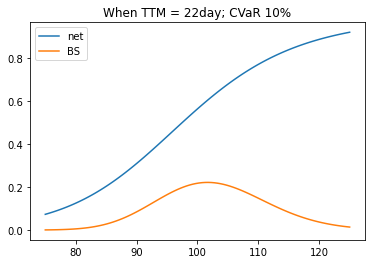

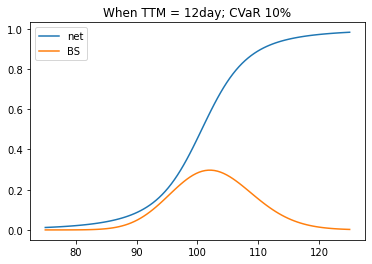

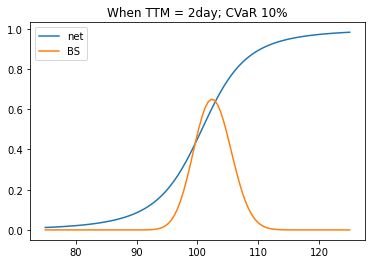

In [ ]:
plt.figure()
l1, = plt.plot(standard_states, predictions_spread_CVaR10.detach().numpy()[:,0,:])
l2, = plt.plot(standard_states, delta_call_spread(standard_states, K1, K2, T_delta*22, r, sigma))
plt.legend(handles=[l1,l2], labels = ['net','BS'], loc='best')
plt.title("When TTM = 22day; CVaR 10%")

plt.figure()
l1, = plt.plot(standard_states, predictions_spread_CVaR10.detach().numpy()[:,10,:])
l2, = plt.plot(standard_states, delta_call_spread(standard_states, K1, K2, T_delta*12, r, sigma))
plt.legend(handles=[l1,l2], labels = ['net','BS'], loc='best')
plt.title("When TTM = 12day; CVaR 10%")

plt.figure()
l1, = plt.plot(standard_states, predictions_spread_CVaR10.detach().numpy()[:,20,:])
l2, = plt.plot(standard_states, delta_call_spread(standard_states, K1, K2, T_delta*2, r, sigma))
plt.legend(handles=[l1,l2], labels = ['net','BS'], loc='best')
plt.title("When TTM = 2day; CVaR 10%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


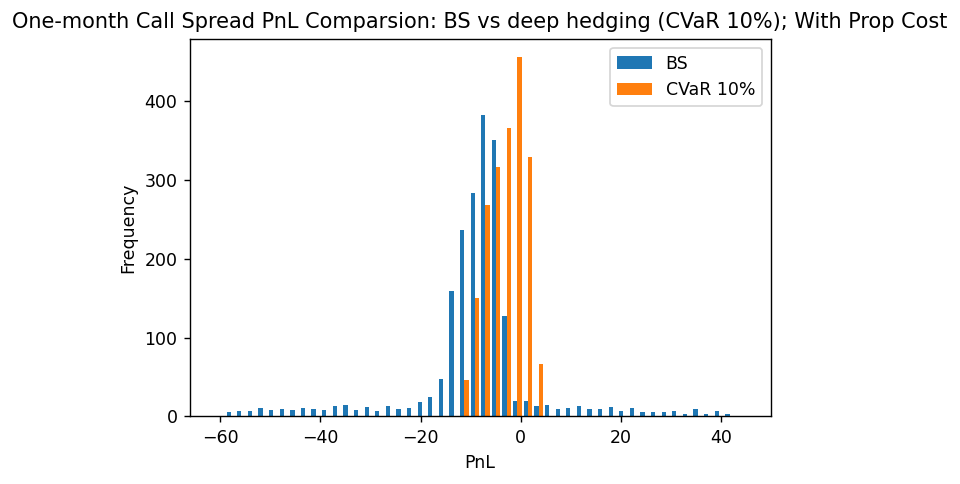

In [ ]:
res_prop_bs = BS_PnL(testing_loader, 'fix')
comparison_plot_5 = plt.figure(dpi = 125, facecolor = 'w')
ax = comparison_plot_5.add_subplot()
ax.set_title('One-month Call Spread PnL Comparsion: BS vs deep hedging (CVaR 10%); With Prop Cost')
ax.hist((res_prop_bs.squeeze(), res_prop_10.detach().numpy()), bins = 50, label=['BS','CVaR 10%'])
ax.set_xlabel('PnL')
ax.set_ylabel('Frequency')
ax.legend()

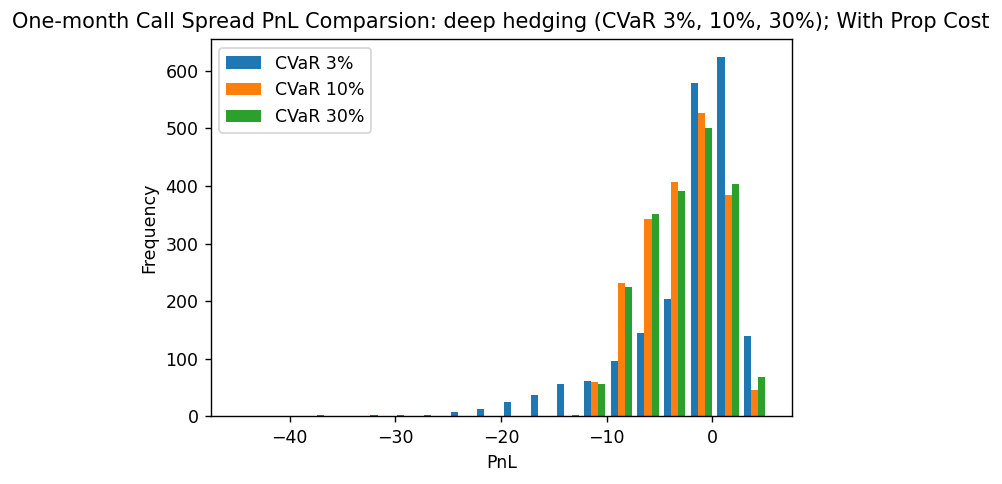

In [ ]:
comparison_plot_6= plt.figure(dpi = 125, facecolor = 'w')
ax = comparison_plot_6.add_subplot()
ax.set_title('One-month Call Spread PnL Comparsion: deep hedging (CVaR 3%, 10%, 30%); With Prop Cost')
ax.hist((res_prop_3.detach().numpy(), res_prop_10.detach().numpy(), res_prop_30.detach().numpy()), bins = 20, label=['CVaR 3%','CVaR 10%','CVaR 30%'])
ax.set_xlabel('PnL')
ax.set_ylabel('Frequency')
ax.legend()

### Conclusion3:
In our one-month hedging experiments for call spread, we set the type of cost as "proportional", then tune the risk-averse parameter to examine the delta and PnL patterns.

Firstly, similar patterns appears as the single option case: as the risk-averse level increases, the PnL is more centered and the left tail is significantly thinner.

Secondly and more interestingly, we focus on the NN delta at different time point during the entire option lifetime. Instead of being like arch shaped as the B-S delta, the NN delta still shows a monotonously increasing pattern. It could be viewed as a smoothed delta for a single european option. The most counter-intuitive difference lies in the OTM area when underlying exceeds the larger strike K2: it is not like the decreasing pattern as in the B-S framework.The main reason may be associated with the output activation function in the RNN network. A tanh or sigmoid function will leads to such a monotonously increasing shape. We cannot say a counter-intuitive pattern is problematic without more valuable metric provided. However, based on the PnL distribution, we argue the network could leads to a right-shifted PnL under market frictions.